In [1]:
import numpy as np
from gridenv import GridEnv
from policy import uniform_policy, random_policy, random_deterministic_policy
from algos import value_iteration
from matplotlib import pyplot as plt
from itertools import product

plt.style.use('config.mlpstyle')
np.random.seed(1234)

# Environment

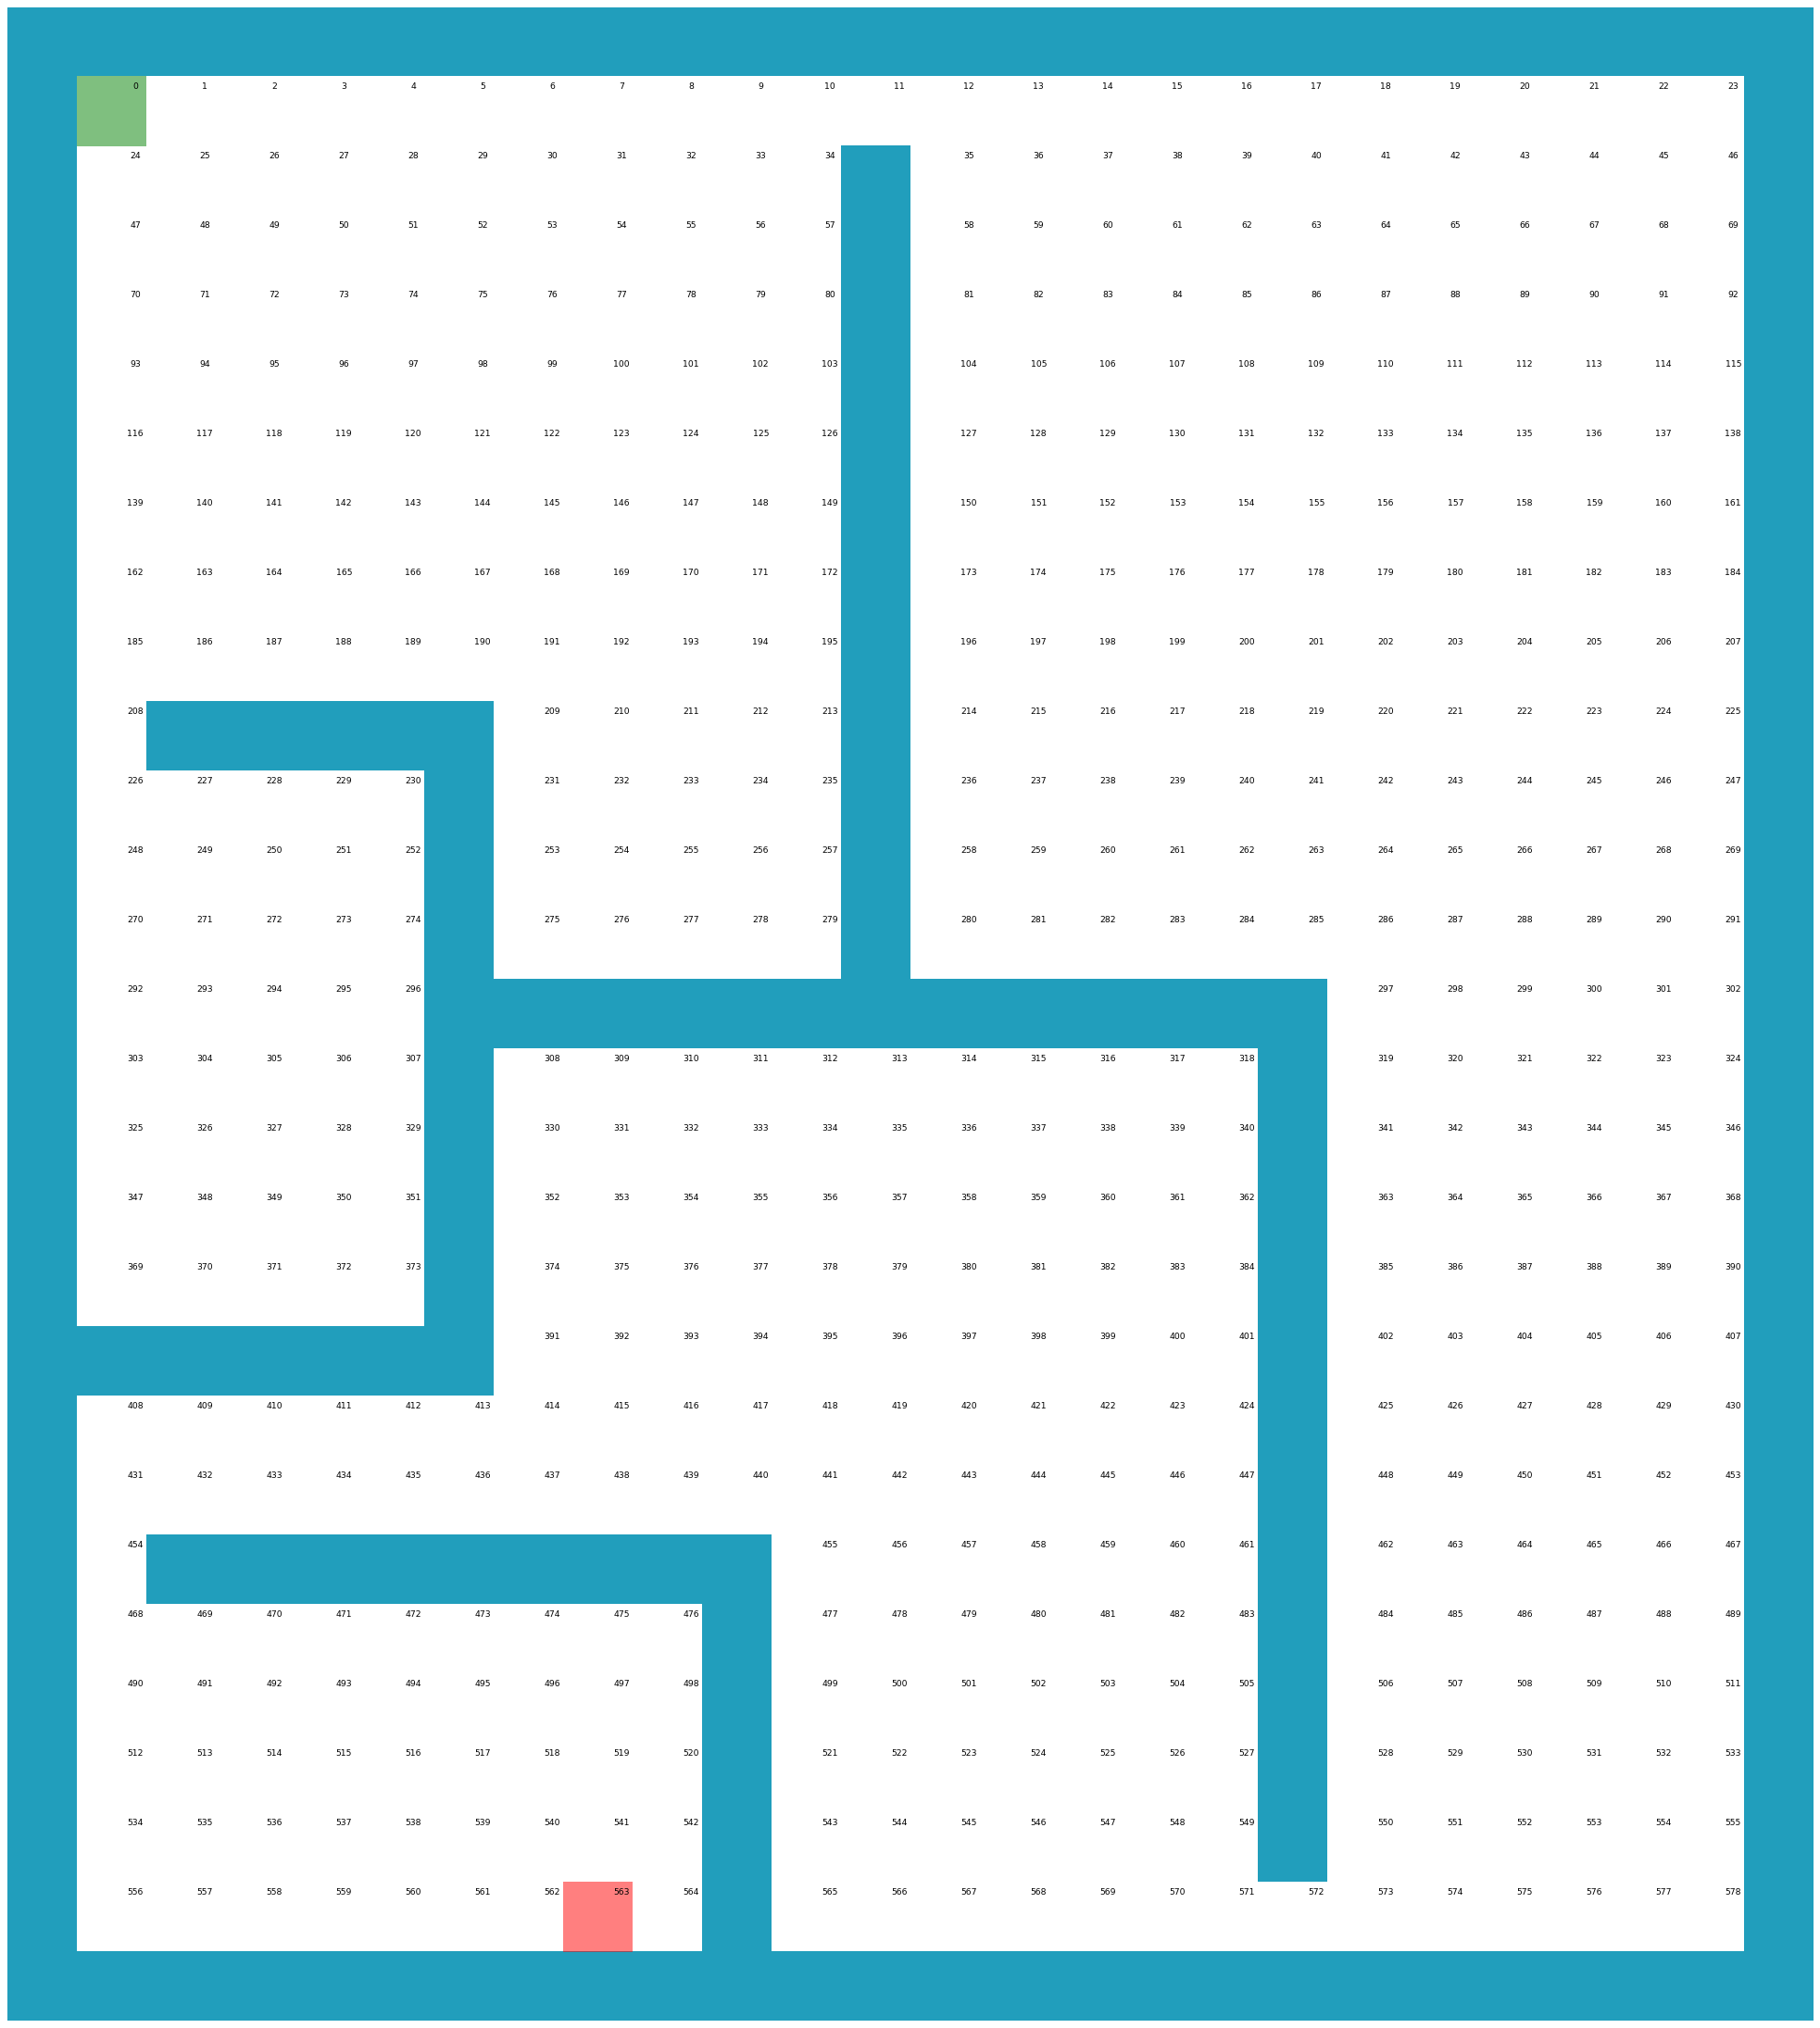

In [2]:
env = GridEnv(filename='grids/hugegrid.txt')
env.show_grid()

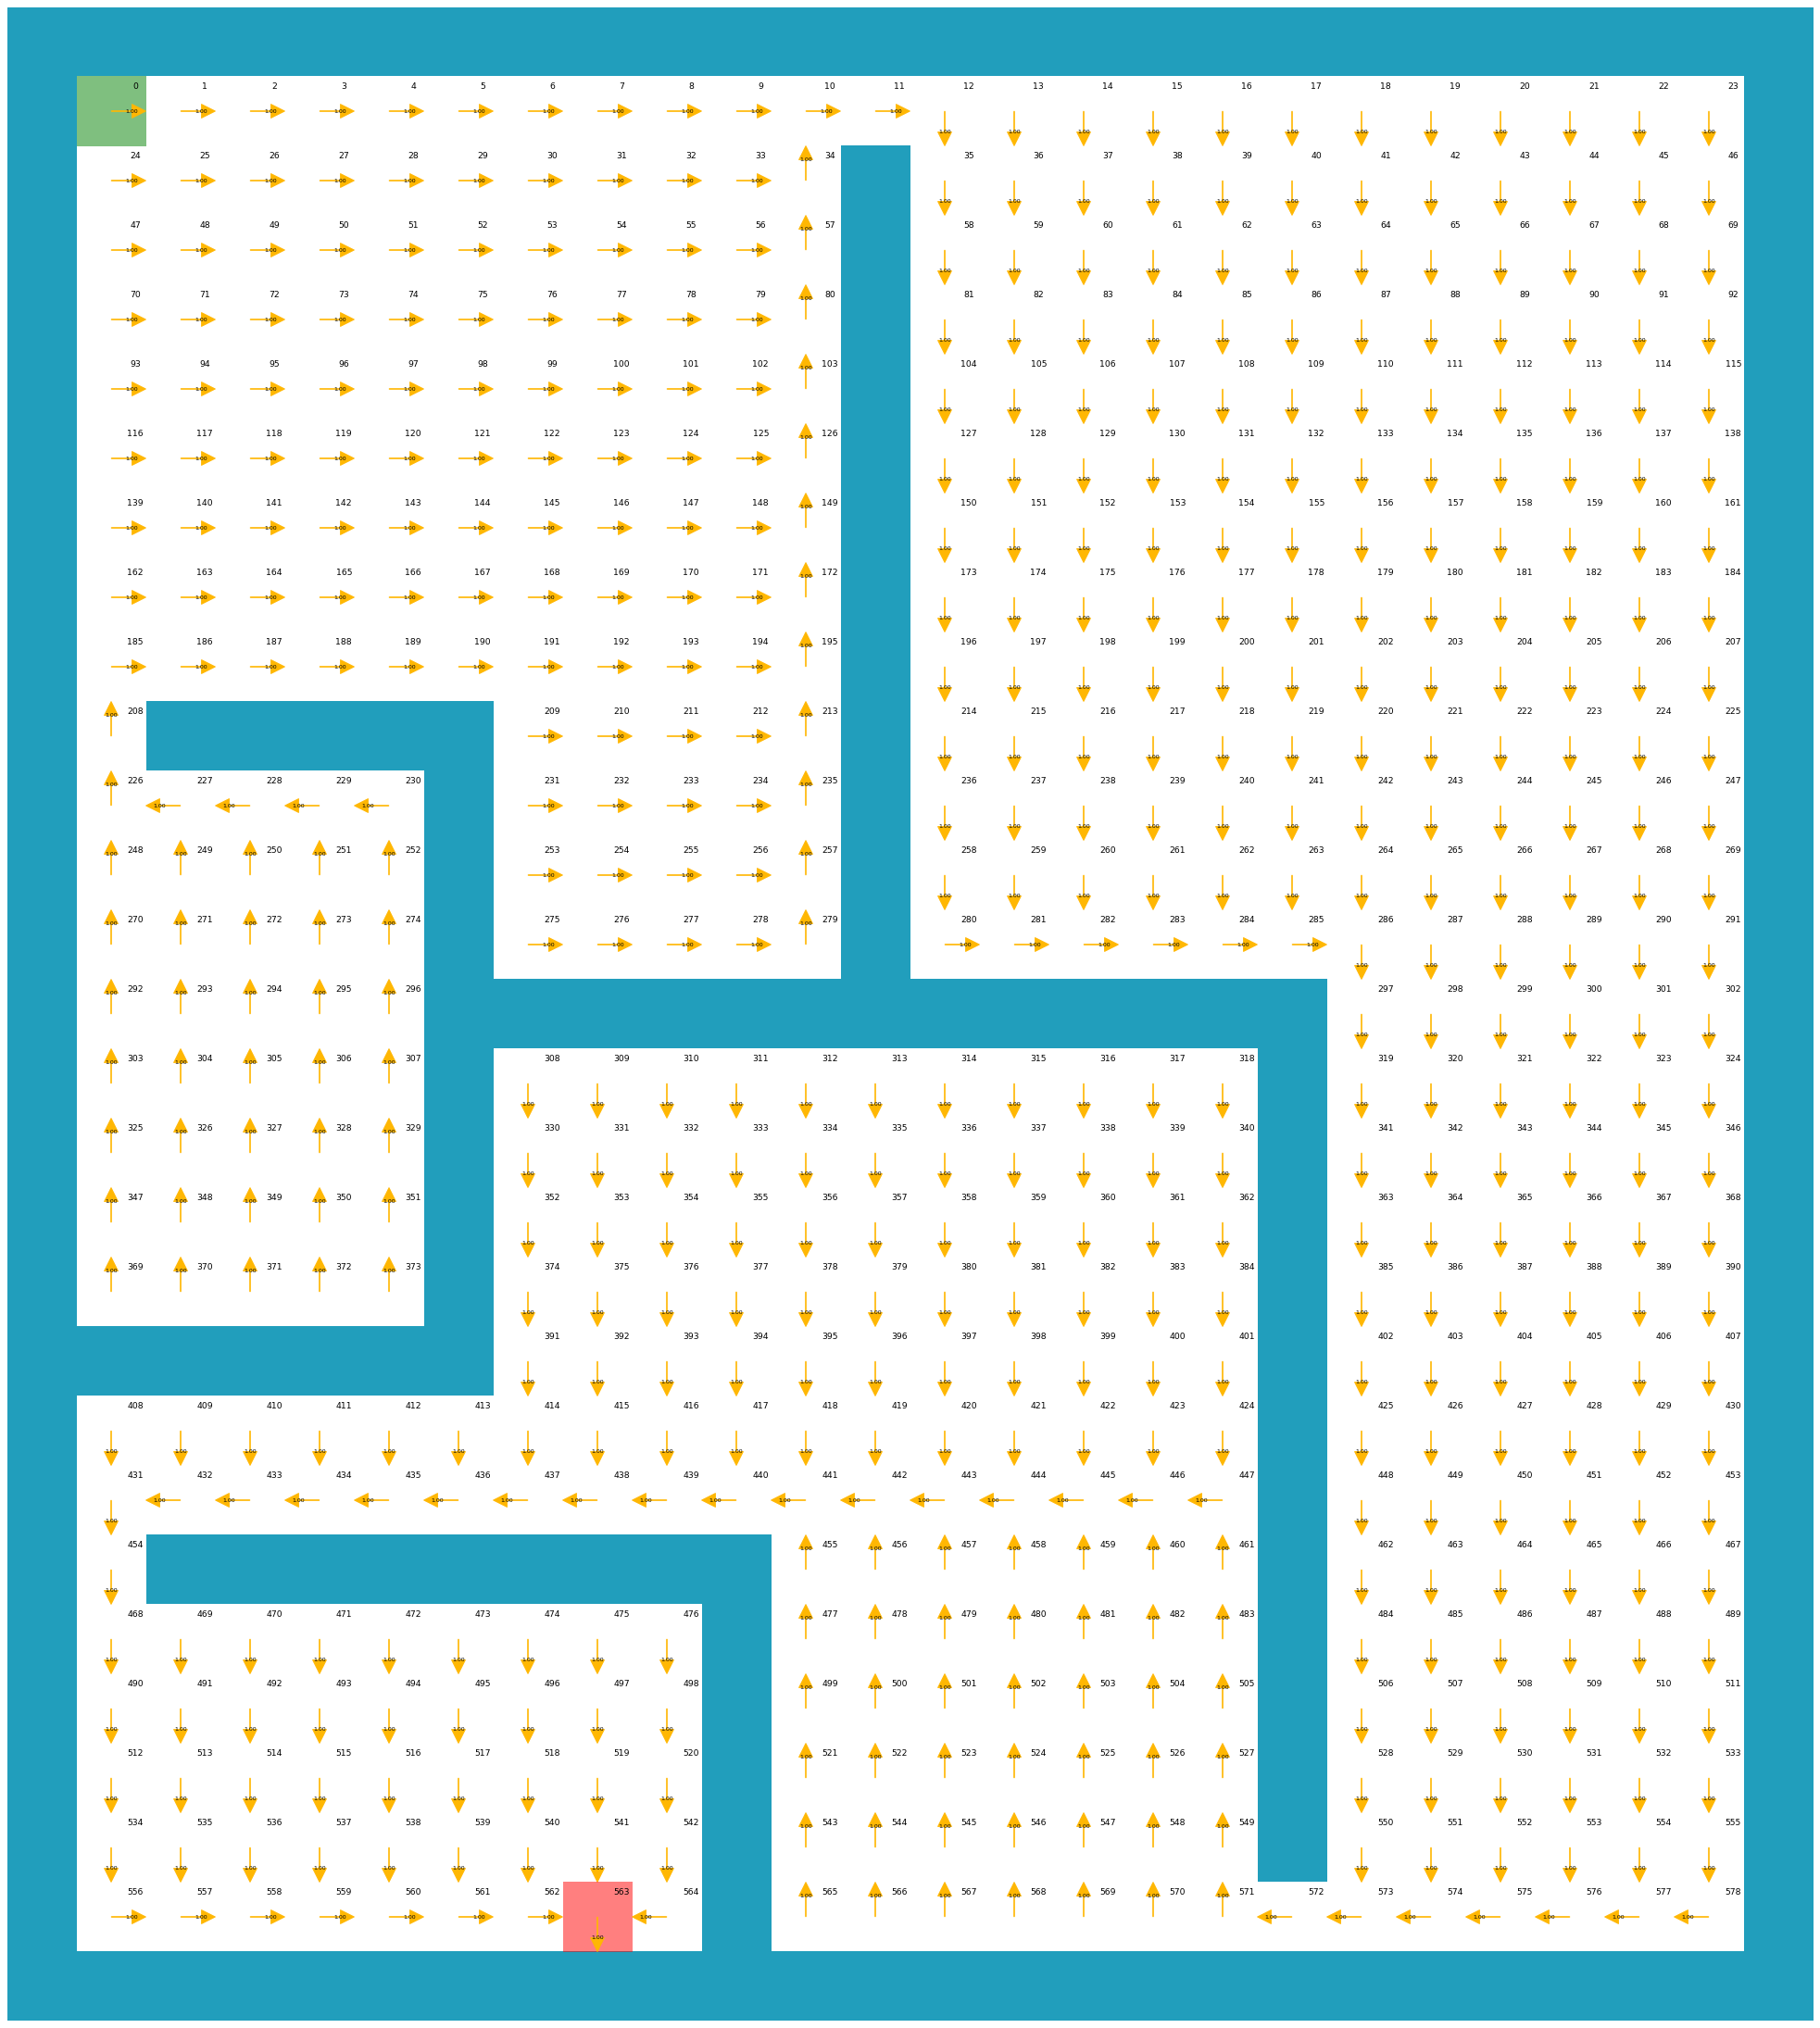

In [3]:
optimal_V, optimal_policy = value_iteration(env.T, env.R)
env.show_grid(policy=optimal_policy)

In [4]:
for idx, (s, v) in enumerate(zip(range(env.n_states), optimal_V)):
    print(f'state: {s}, V*(s) = {v}')
    if idx == 5:
        print("...")
        break

state: 0, V*(s) = 0.44752321376381066
state: 1, V*(s) = 0.4520436502664754
state: 2, V*(s) = 0.45660974774391455
state: 3, V*(s) = 0.4612219674180955
state: 4, V*(s) = 0.4658807751697934
state: 5, V*(s) = 0.47058664158564995
...


In [5]:
def compute_P_pi(transition_matrix, policy):
    n_states, n_actions = policy.shape
    P = np.zeros((n_states, n_states))
    for i in range(n_states):
        P[i, :] = transition_matrix[i, :, :].T @ policy[i, :]
    return P


def compute_r_pi(R, policy):
    r = policy * R
    r = np.sum(r, axis=1)
    return r

# V function approximation
We can approximate the value function as:
$$
V_{\phi, w} = \phi(s)^\top w
$$
Where, $\phi : \mathcal{S} \rightarrow \mathbb{R}^k$ is the feature matrix obtained by taking the $k$-th smoothest eigenvectors of the Laplacian (corresponding to the smallest eigenvalues)
Given the feature matrix $\Phi$ and the value function $V$ we can find the optimal weights vector via least square, in closed form:
$$
w = (\Phi^\top \Phi)^{-1} \Phi^\top V
$$

In [6]:
def compute_V_pi(transition_matrix, R, policy, gamma=.99):
    r_pi = compute_r_pi(R, policy)
    P_pi = compute_P_pi(transition_matrix, policy)
    n_states = P_pi.shape[0]
    I = np.eye(n_states, n_states)
    V = np.linalg.solve(I - gamma * P_pi, r_pi)
    return V

def compute_approximate_V_pi(L, k, V):
    U, _, _ = np.linalg.svd(L)
    phi = U[:, -k:]
    weights = np.linalg.solve(phi.T@phi, phi.T@V)
    V_pred = phi @ weights
    return V_pred


# Q function approximation
We can approximate the state action value function as:
$$
Q_{\phi, w} = \phi(s, a)^T w
$$
Here Q is vectorized and $\phi : \mathcal{S} \rightarrow \mathbb{R}^k$ is the feature matrix obtained by taking the $k$-th smoothest eigenvectors of the Laplacian constructed from state action pairs (corresponding to the smallest eigenvalues)
Given the feature matrix $\Phi \in \mathbb{R}^{|S|\times|A|}$ and the state action value function $Q$ we can find the optimal weights vector via least square, in closed form:
$$
w = (\Phi^\top \Phi)^{-1} \Phi^\top Q
$$

In [7]:
def compute_Q_pi(transition_matrix, R, policy, gamma=.99):
    V_pi = compute_V_pi(transition_matrix, R, policy)
    n_states, n_actions = policy.shape

    Q = R.copy()
    for s in range(n_states):
        for a in range(n_actions):
            Q[s, a] = R[s, a] + gamma * np.sum([prob * V_pi[next_s] for next_s, prob in enumerate(transition_matrix[s, a, :])])
    return Q

def Q_to_vec(Q):
    n_states, n_actions = Q.shape
    Q_vec = np.zeros(n_states * n_actions)
    for idx, (s, a) in enumerate(list(product(list(range(n_states)), list(range(n_actions))))):
        Q_vec[idx] = Q[s, a]
    return Q_vec

def compute_approximate_Q_pi(L, k, Q):
    U, _, _ = np.linalg.svd(L)
    phi = U[:, -k:] # \phi(s, a)
    Q_vec = Q_to_vec(Q)
    weights = np.linalg.solve(phi.T@phi, phi.T@Q_vec)
    Q_pred = phi @ weights
    return Q_pred

In [8]:
# check correctness
policy = uniform_policy(env.n_states, env.n_actions)
Q_pi = compute_Q_pi(env.T, env.R, policy)
V_pi = compute_V_pi(env.T, env.R, policy)
for s in range(env.n_states):
    for a in range(env.n_actions):
        print(f'state: {s}, action: {a} Q(s, a) = {Q_pi[s, a]:.5f}')
    break

state: 0, action: 0 Q(s, a) = 0.00000
state: 0, action: 1 Q(s, a) = 0.00000
state: 0, action: 2 Q(s, a) = 0.00000
state: 0, action: 3 Q(s, a) = 0.00000


In [9]:
# check correctness
V_from_Q = np.zeros(env.n_states)

for s in range(env.n_states):
    for a in range(env.n_actions):
        V_from_Q[s] += Q_pi[s, a] * policy[s, a]

for idx, (s, v) in enumerate(zip(range(env.n_states), V_from_Q)):
    print(f'state: {s}, V_from_Q(s) = {v:.5f}, V(s) = {V_pi[s]:.5f}')
    if idx > 4: break

state: 0, V_from_Q(s) = 0.00000, V(s) = 0.00000
state: 1, V_from_Q(s) = 0.00000, V(s) = 0.00000
state: 2, V_from_Q(s) = 0.00000, V(s) = 0.00000
state: 3, V_from_Q(s) = 0.00000, V(s) = 0.00000
state: 4, V_from_Q(s) = 0.00000, V(s) = 0.00000
state: 5, V_from_Q(s) = 0.00000, V(s) = 0.00000


# Error measure
The metric used for the approximation error is the MSE, normalized by the number of states $|S|$:
$$
MSE(V, V_{\phi, w}) = \frac{1}{|S|} \sum_{s \in \mathcal{S}} (V(s) - V_{\phi, w}(s))^2
$$
Similarily, for the state action function $Q$:
$$
MSE(Q, Q_{\phi, w}) = \frac{1}{|S||A|} \sum_{s \in \mathcal{S}} (Q(s, a) - Q_{\phi, w}(s, a))^2
$$

In [10]:
def plot_approximation_error_state(L, L_norm, policy, V, title="", k_step=1):
    n_states = policy.shape[0]
    K = list(range(1, env.n_states + 1, k_step))
    err_vec_comb = []
    err_vec_norm = []

    for k in K:
        V_pred = compute_approximate_V_pi(L, k, V)
        err_vec_comb.append(np.mean((V_pred - V)**2) / n_states)
        V_pred = compute_approximate_V_pi(L_norm, k, V)
        err_vec_norm.append(np.mean((V_pred - V)**2) / n_states)

    plt.figure(figsize=(7, 3))
    steps = max(n_states // (10 * k_step), 1)
    plt.plot(K, err_vec_comb, c='orange', marker='o', markevery=steps, label='Laplacian')
    plt.plot(K, err_vec_norm, c='blue', marker='v', markevery=steps, label='Normalized Laplacian')
    plt.title(title)
    plt.xlabel('K (number of eigenvectors considered)')
    #plt.yscale("log")
    plt.ylabel(r'MSE($V^\pi, V_{\phi, w}^\pi$)')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend()
    plt.show()

In [11]:
def plot_approximation_error_state_action(L, L_norm, policy, Q, title="", k_step=1):
    n_states, n_actions = policy.shape
    Q_vec = Q_to_vec(Q)
    K = list(range(1, env.n_states + 1, k_step))
    err_vec_comb = []
    err_vec_norm = []
    for k in K:
        Q_pred = compute_approximate_Q_pi(L, k, Q)
        err_vec_comb.append(np.mean((Q_pred - Q_vec)**2) / (n_states * n_actions))
        Q_pred = compute_approximate_Q_pi(L_norm, k, Q)
        err_vec_norm.append(np.mean((Q_pred - Q_vec)**2) / (n_states * n_actions))

    plt.figure(figsize=(7, 3))
    steps = max(n_states // (10 * k_step), 1)
    plt.plot(K, err_vec_comb, c='orange', marker='o', markevery=steps, label='Laplacian')
    plt.plot(K, err_vec_norm, c='blue', marker='v', markevery=steps, label='Normalized Laplacian')
    plt.title(title)
    plt.xlabel('K (number of eigenvectors considered)')
    #plt.yscale("log")
    plt.ylabel(r'MSE($Q^\pi, Q_{\phi, w}^\pi$)')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.legend()
    plt.show()

# Policies
The graph laplacian (both combinatorial and normalized laplacian) is created via random walk, i.e., the uniform policy. Given the graph laplacian, we compute the $V^\pi$ and $Q^\pi$ and the approximated $V_{\phi, w}^\pi$ and $Q_{\phi, w}^\pi$ (for different number of eigenvector $k$ selected) for 3 different policies:
- uniform policy
- random stochastic policy
- random deterministic policy

Then we compare the error between the real and approximated functions $MSE(V^\pi, V_{\phi, w}^\pi)$ and $MSE(Q^\pi, V_{\phi, w}^\pi)$

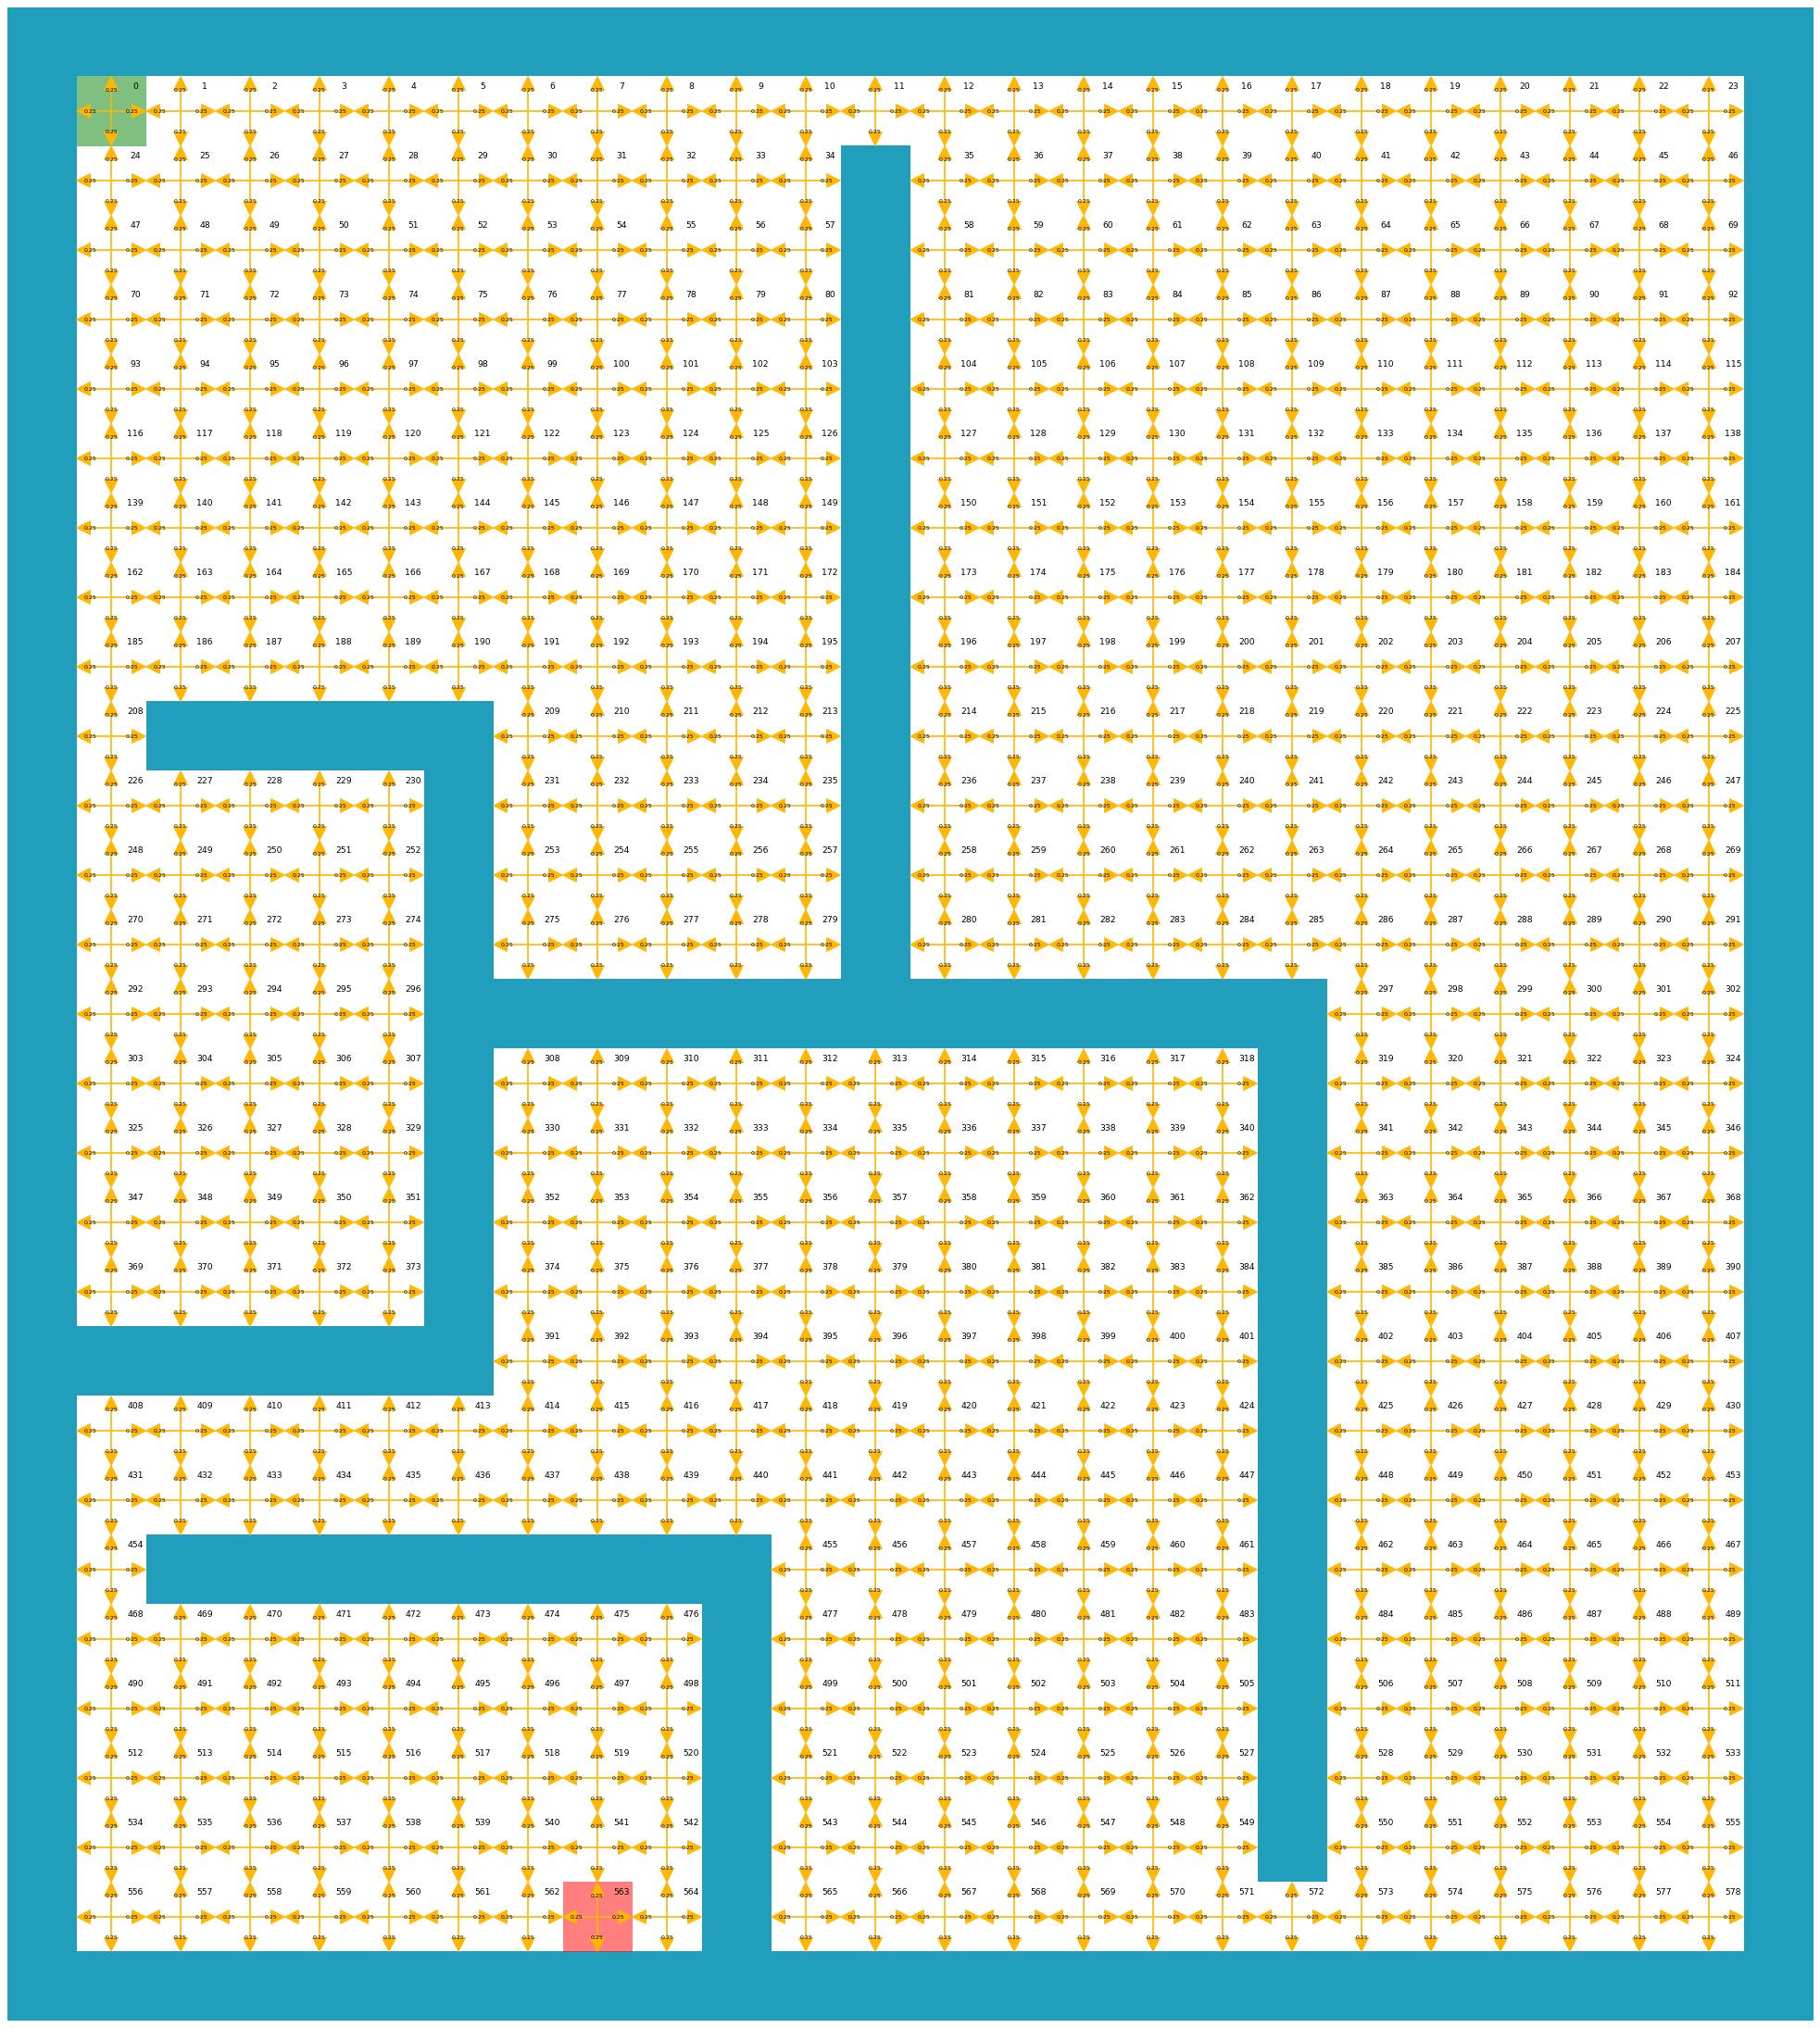

In [12]:
policy_uniform = uniform_policy(env.n_states, env.n_actions)
env.show_grid(policy=policy_uniform)

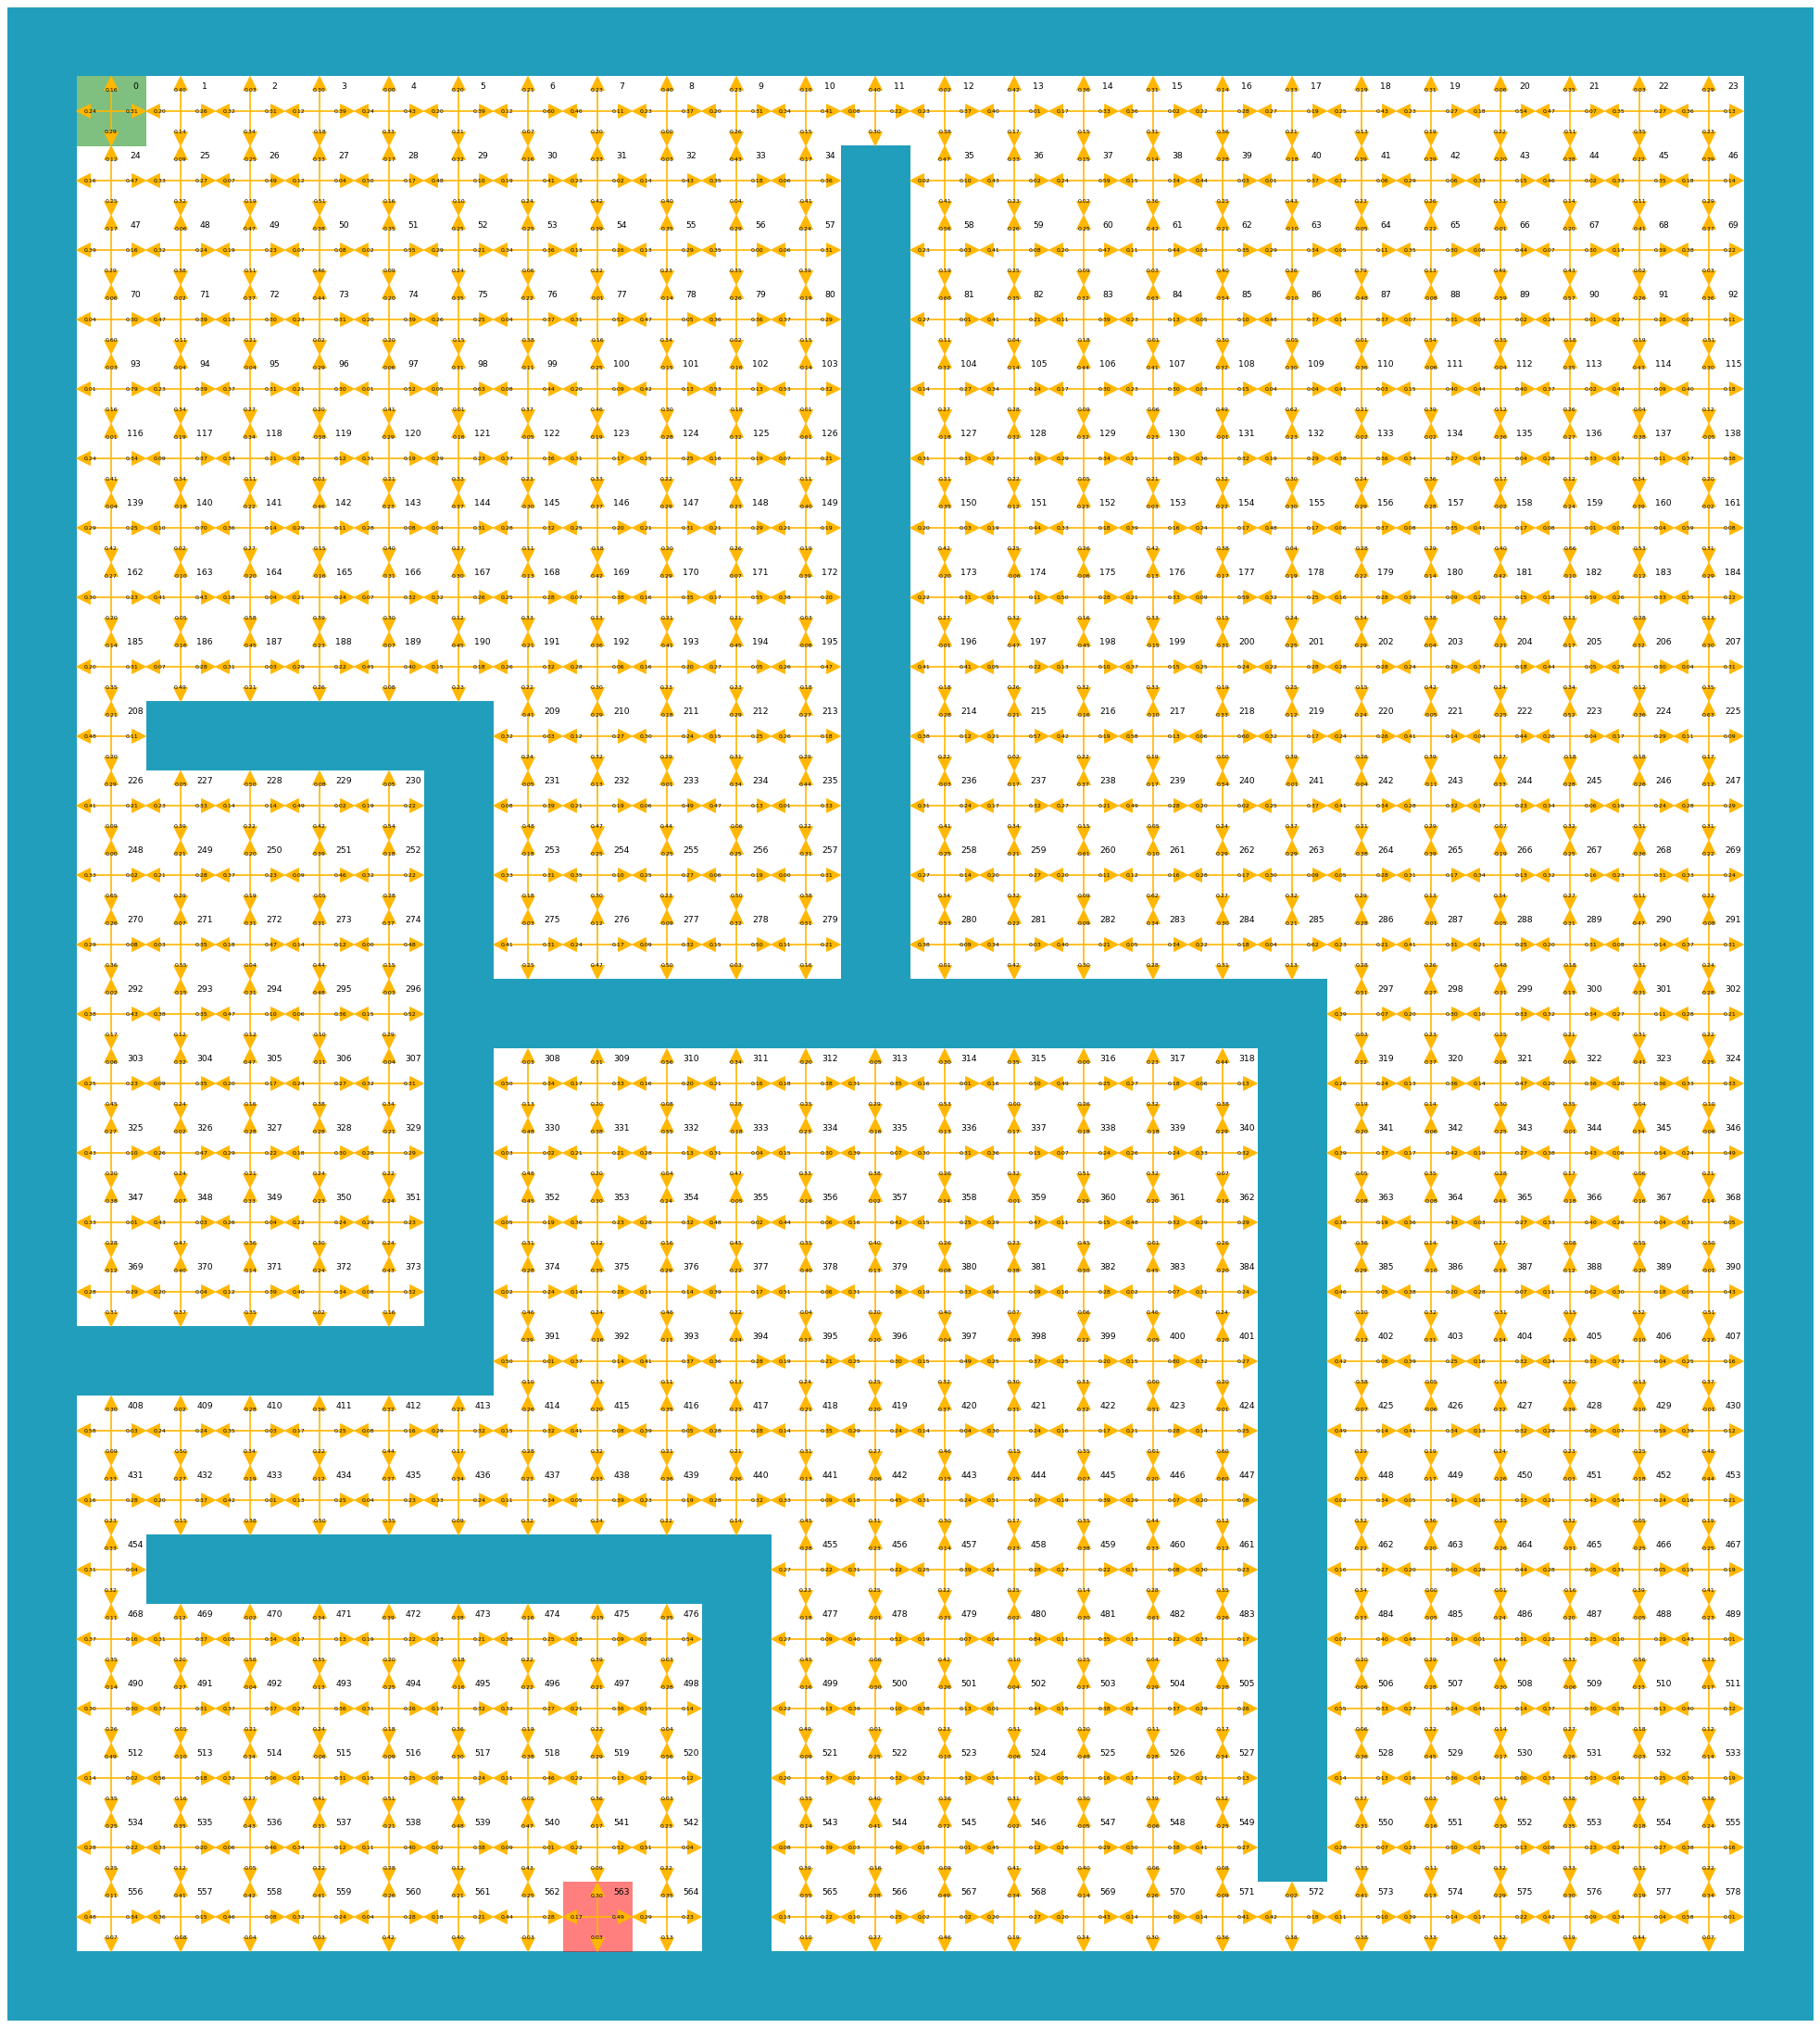

In [13]:
policy_random = random_policy(env.n_states, env.n_actions)
env.show_grid(policy=policy_random)

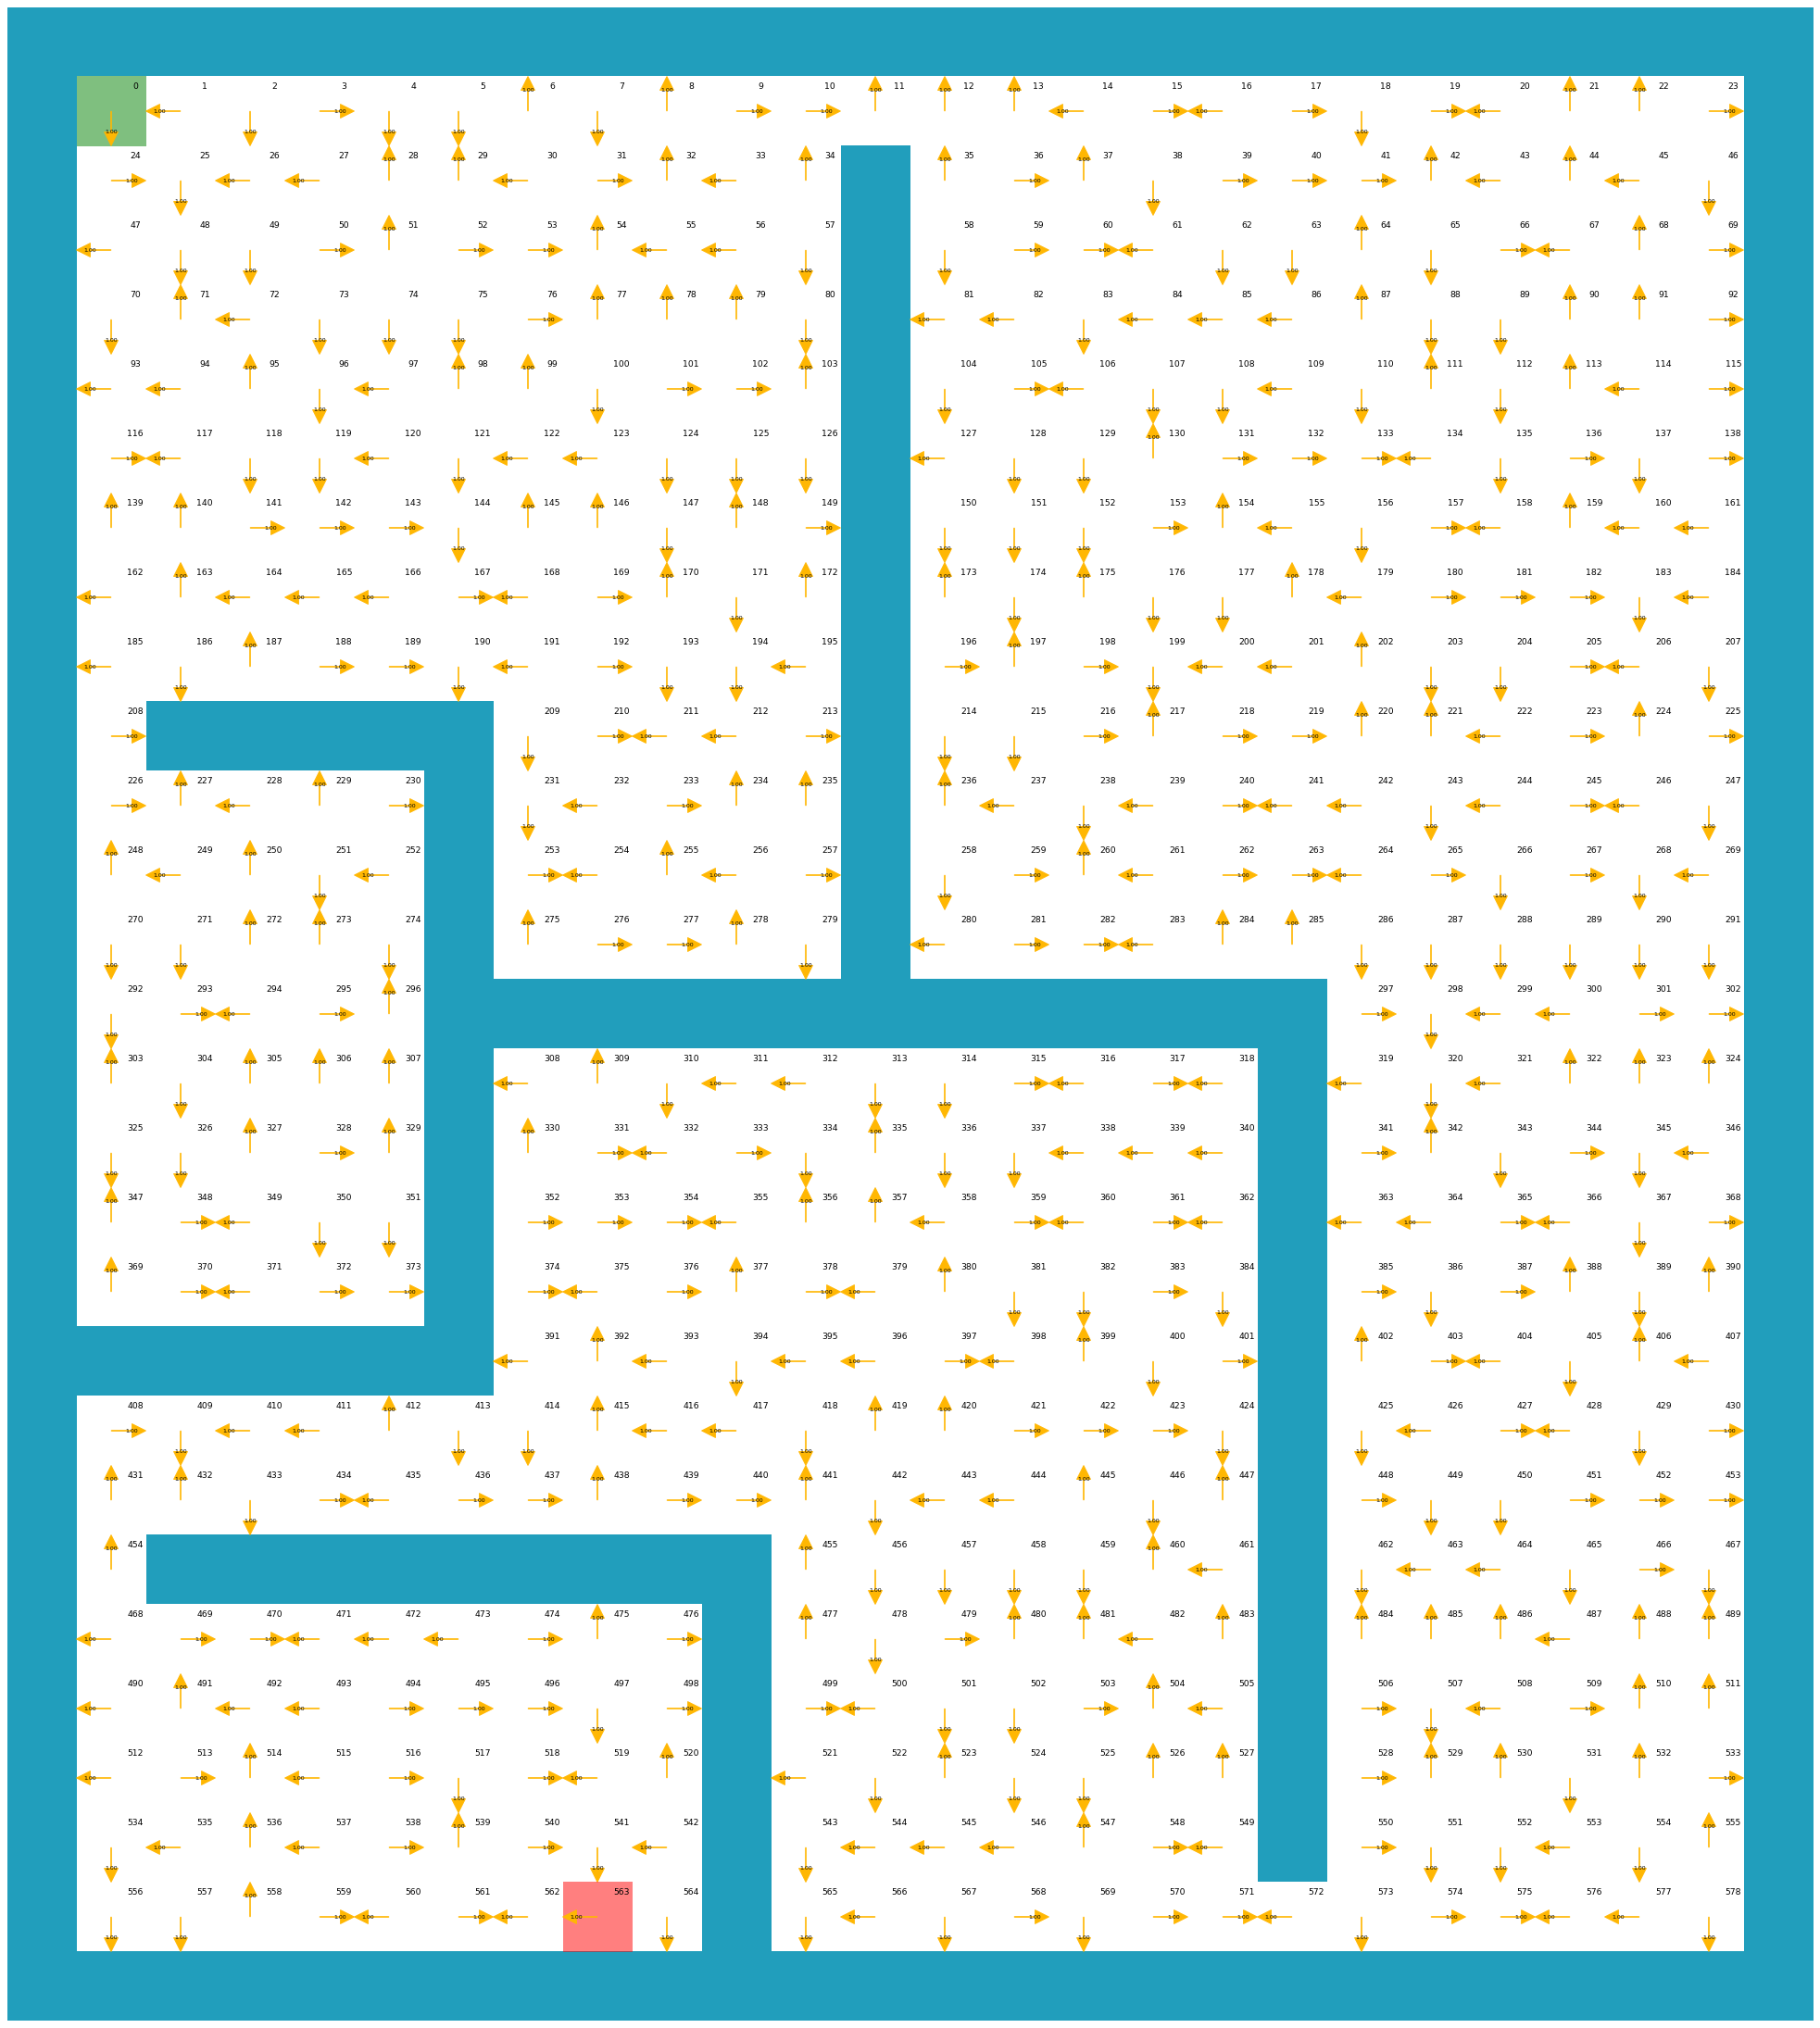

In [14]:
policy_random_deterministic = random_deterministic_policy(env.n_states, env.n_actions)
env.show_grid(policy=policy_random_deterministic)

# V function evaluation 

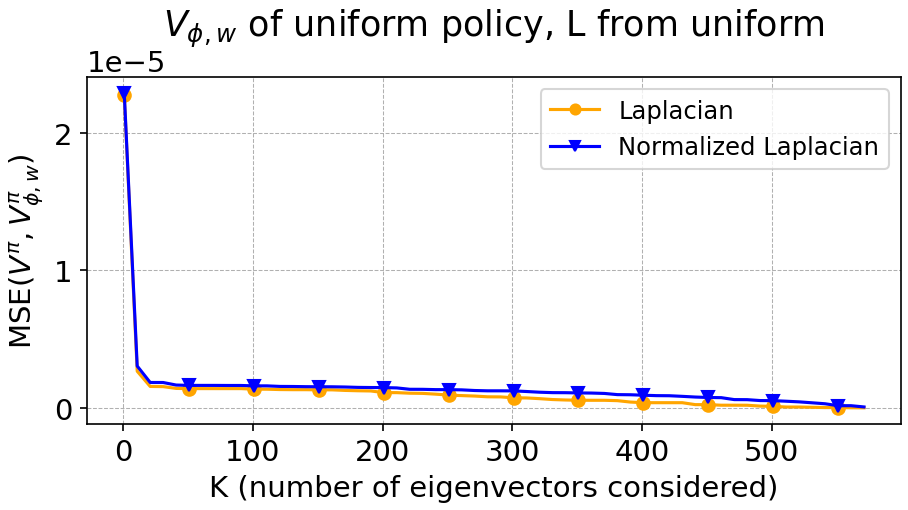

In [15]:
V = compute_V_pi(env.T, env.R, policy_uniform)
plot_approximation_error_state(env.L, env.L_norm, policy_uniform, V, r'$V_{\phi, w}$ of uniform policy, L from uniform', k_step=10)

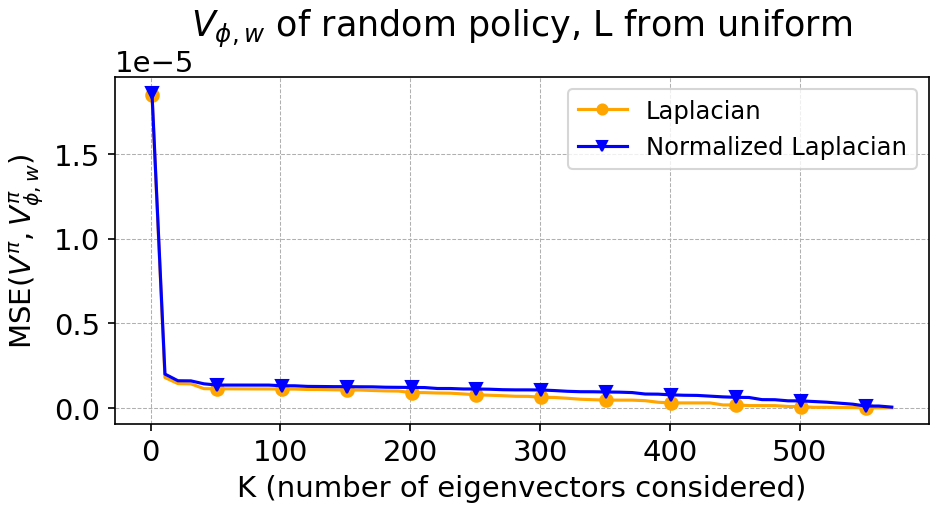

In [16]:
V = compute_V_pi(env.T, env.R, policy_random)
plot_approximation_error_state(env.L, env.L_norm, policy_random, V, r'$V_{\phi, w}$ of random policy, L from uniform', k_step=10)

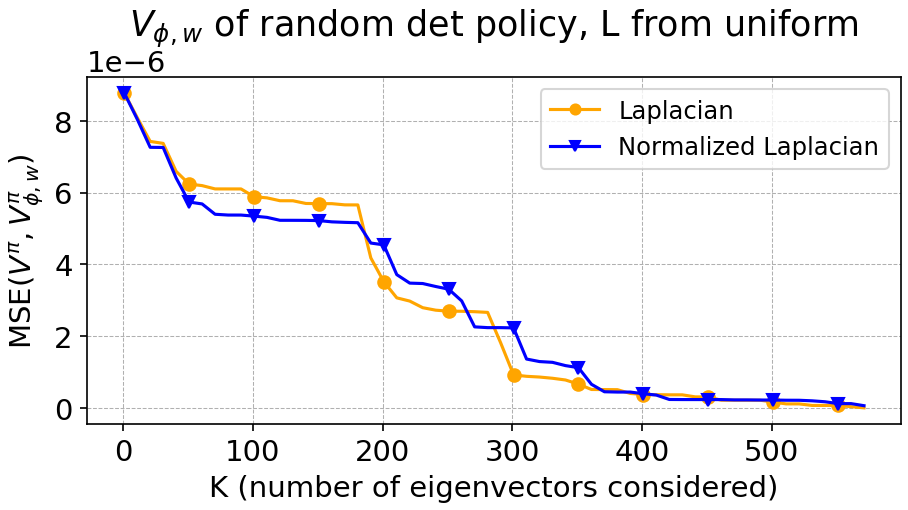

In [17]:
V = compute_V_pi(env.T, env.R, policy_random_deterministic)
plot_approximation_error_state(env.L, env.L_norm, policy_random_deterministic, V, r'$V_{\phi, w}$ of random det policy, L from uniform', k_step=10)

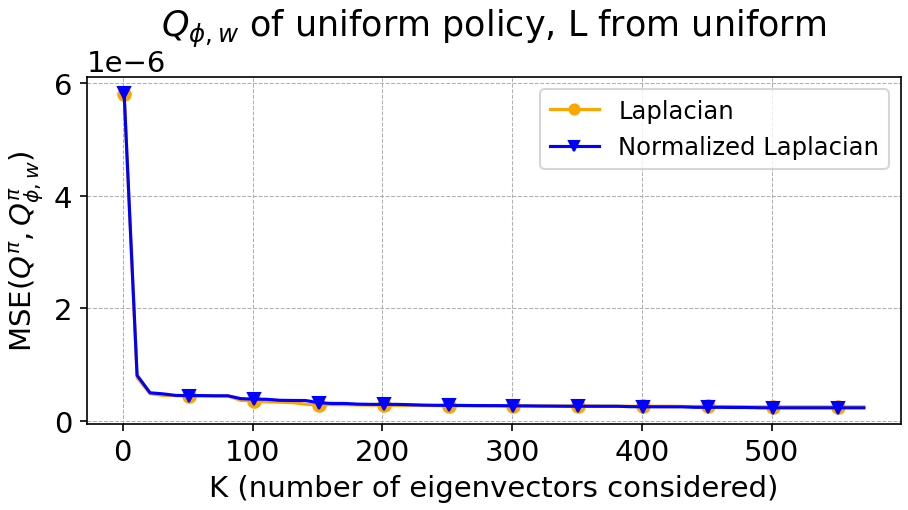

In [18]:
Q = compute_Q_pi(env.T, env.R, policy_uniform)
plot_approximation_error_state_action(env.L_u_sa, env.L_u_sa_norm, policy, Q, r'$Q_{\phi, w}$ of uniform policy, L from uniform', k_step=10)

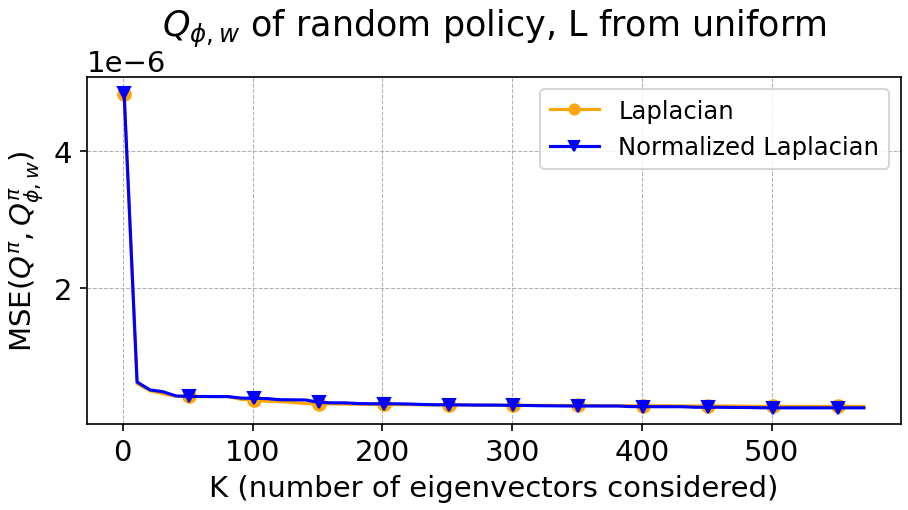

In [19]:
Q = compute_Q_pi(env.T, env.R, policy_random)
plot_approximation_error_state_action(env.L_u_sa, env.L_u_sa_norm, policy, Q, r'$Q_{\phi, w}$ of random policy, L from uniform', k_step=10)

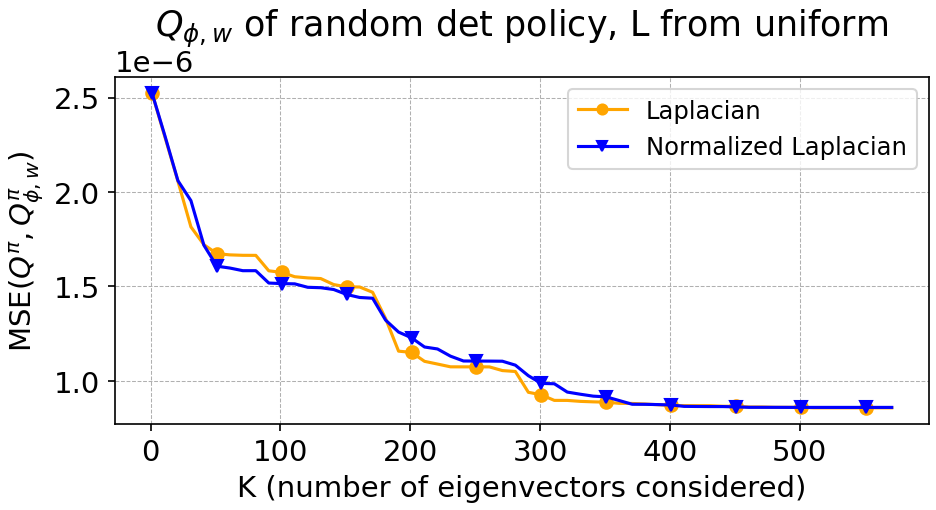

In [20]:
Q = compute_Q_pi(env.T, env.R, policy_random_deterministic)
plot_approximation_error_state_action(env.L_u_sa, env.L_u_sa_norm, policy, Q, r'$Q_{\phi, w}$ of random det policy, L from uniform', k_step=10)